<h1> Price optimization <h1>

Optimum prices prediction for car owners using Machine Learning

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore") # to avoid deprecation warnings
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt



<h2> Upload and take a first look at the dataset <h2>

In [4]:
df_price = pd.read_csv('get_around_pricing_project.csv')

<h4> Preview <h4>

In [ ]:
# Basic stats
print("Number of rows : {}".format(df_price.shape[0]))
print()

print("Display of df_price: ")
display(df_price.head())
print()

print("Basics statistics: ")
data_desc = df_price.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*df_price.isnull().sum()/df_price.shape[0])

Number of rows : 4843

Display of df_price: 


,Unnamed: 0,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183



Basics statistics: 


,Unnamed: 0,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
count,4843.000000,4843,4.843000e+03,4843.00000,4843,4843,4843,4843,4843,4843,4843,4843,4843,4843,4843.000000
unique,NaN,28,NaN,NaN,4,10,8,2,2,2,2,2,2,2,NaN
top,NaN,Citroën,NaN,NaN,diesel,black,estate,True,True,False,False,False,False,True,NaN
freq,NaN,969,NaN,NaN,4641,1633,1606,2662,3839,3865,3881,2613,3674,4514,NaN
mean,2421.000000,NaN,1.409628e+05,128.98823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.214536
std,1398.198007,NaN,6.019674e+04,38.99336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.568268
min,0.000000,NaN,-6.400000e+01,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.000000
25%,1210.500000,NaN,1.029135e+05,100.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.000000
50%,2421.000000,NaN,1.410800e+05,120.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.000000
75%,3631.500000,NaN,1.751955e+05,135.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.000000



Percentage of missing values: 


Unnamed: 0                   0.0
model_key                    0.0
mileage                      0.0
engine_power                 0.0
fuel                         0.0
paint_color                  0.0
car_type                     0.0
private_parking_available    0.0
has_gps                      0.0
has_air_conditioning         0.0
automatic_car                0.0
has_getaround_connect        0.0
has_speed_regulator          0.0
winter_tires                 0.0
rental_price_per_day         0.0
dtype: float64

- No missing values
- Possible outlier, especially for mileage that have a negative value as minimum which is impossible, we also notice very high numbers in engine power, and rental price

<h4> Cleaning <h4>

Suppression of the 'Unnamed: 0' column, which is a doublon of the index column

In [5]:
df_price = df_price.drop('Unnamed: 0', axis= 1 )

Drop lines containing outliers [Xˉ−3σ, Xˉ+3σ]

In [6]:

liste_col = ['mileage', 'engine_power', 'rental_price_per_day']
for element in liste_col:
    inf_limit = (df_price[element].mean() - (3 *(df_price[element].std()) ))
    sup_limit = (df_price[element].mean() + (3 *(df_price[element].std())))
    mask = ((df_price[element] > inf_limit) & (df_price[element] < sup_limit))
    df_price = df_price.loc[mask,:]
print('Rows:',df_price.shape [0])

Rows: 4705


Suppression of underrepresented car brand

Some car brand in the model_key features have very few occurence, which make it hard to make solid conclusion and can cause problem of 'unknown categories' in the preprocessing after the splitting as some brand can appear in the test set and not in the train during the fit transform

In [ ]:
df_price.model_key.value_counts()

Citroën       947
Renault       902
BMW           811
Peugeot       627
Audi          514
Nissan        273
Mitsubishi    217
Mercedes       97
Volkswagen     61
Toyota         45
SEAT           44
PGO            33
Opel           33
Ferrari        32
Subaru         30
Name: model_key, dtype: int64

In [7]:
for model in df_price.model_key.value_counts().index:
    if df_price.model_key.value_counts()[model] < 30:
        mask = ~(df_price['model_key'] == model)
        df_price = df_price.loc[mask,:]

In [ ]:
df_price.model_key.value_counts()

Citroën       947
Renault       902
BMW           811
Peugeot       627
Audi          514
Nissan        273
Mitsubishi    217
Mercedes       97
Volkswagen     61
Toyota         45
SEAT           44
PGO            33
Opel           33
Ferrari        32
Subaru         30
Name: model_key, dtype: int64

Saving of the clean dataset in order to use it for the API

In [9]:
df_price_clean = df_price
df_price_clean.to_csv(r'C:\Users\flori\OneDrive\Bureau\Formation Datascience\Module_8_Deployment\Projet_deployment\Jedha_Project_Getaround\Price_prediction_FASTAPI\df_price_clean.csv')

<h2> EDA <h2>

In [16]:
fig_vis= make_subplots(rows = 14, cols = 2, subplot_titles = ("Feature distribution", "Target in function of the feature"), row_heights= [700 for i in range(0,14)])
n_row = 1
for col in df_price.columns:

    fig = (px.scatter(x = df_price.loc[:,col], 
                        y = (df_price.loc[:,'rental_price_per_day']) ))
    fig_vis.add_trace(fig.data[0], 
                    row = n_row,
                    col = 2,
                     )

    fig_vis.add_trace(go.Histogram(x = df_price[col], nbinsx = df_price[col].nunique(), marker=dict(color='#1f77b4')), 
                row = n_row,
                col = 1,
                 )

    n_row +=1

fig_vis.update_layout(
    height=3500, 
    width=1500,
    yaxis1_title = 'Count',
    yaxis2_title = 'rental_price_per_day',
    yaxis3_title = 'Count',
    yaxis4_title = 'rental_price_per_day',
    yaxis5_title = 'Count',
    yaxis6_title = 'rental_price_per_day',
    yaxis7_title = 'Count',
    yaxis8_title = 'rental_price_per_day',
    yaxis9_title = 'Count',
    yaxis10_title = 'rental_price_per_day',
    yaxis11_title = 'Count',
    yaxis12_title = 'rental_price_per_day',
    yaxis13_title = 'Count',
    yaxis14_title = 'rental_price_per_day',
    yaxis15_title = 'Count',
    yaxis16_title = 'rental_price_per_day',
    yaxis17_title = 'Count',
    yaxis18_title = 'rental_price_per_day',
    yaxis19_title = 'Count',
    yaxis20_title = 'rental_price_per_day',
    yaxis21_title = 'Count',
    yaxis22_title = 'rental_price_per_day',
    xaxis1_title = 'model_key',
    xaxis2_title = 'model_key',
    xaxis3_title = 'mileage',
    xaxis4_title = 'mileage',
    xaxis5_title = 'engine_power',
    xaxis6_title = 'engine_power',
    xaxis7_title = 'fuel',
    xaxis8_title = 'fuel',   
    xaxis9_title = 'paint_color',
    xaxis10_title = 'paint_color',
    xaxis11_title = 'car_type',
    xaxis12_title = 'car_type',
    xaxis13_title = 'private_parking_available',
    xaxis14_title = 'private_parking_available',
    xaxis15_title = 'has_gps',
    xaxis16_title = 'has_gps',
    xaxis17_title = 'has_air_conditioning',
    xaxis18_title = 'has_air_conditioning',
    xaxis19_title = 'automatic_car',
    xaxis20_title = 'automatic_car',
    xaxis21_title = 'has_getaround_connect',
    xaxis22_title = 'has_getaround_connect',
    xaxis23_title = 'has_speed_regulator',
    xaxis24_title = 'has_speed_regulator',
    xaxis25_title = 'winter_tires',
    xaxis26_title = 'winter_tires',
    xaxis27_title ='rental_price_per_day',
    xaxis28_title ='rental_price_per_day',
    
    title={
        'y':0.99,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    showlegend = False,
    margin=go.layout.Margin(l=150,
                                                r=50,
                                                b=80,
                                                t=80,
                                                pad = 4
                                                ),
) 
fig_vis.update_annotations(yshift=30)

We can make some observations on these graphs:
- The target (rental price per day) and the mileage feature got a almost normal distribution
- The price seems to obviously increase with the engine power and decrease with the mileage
- Hybrid petrol and electric car seems to be more expensive, but there is too few data to obtain a solid conclusion

Correlation matrix

<AxesSubplot:>

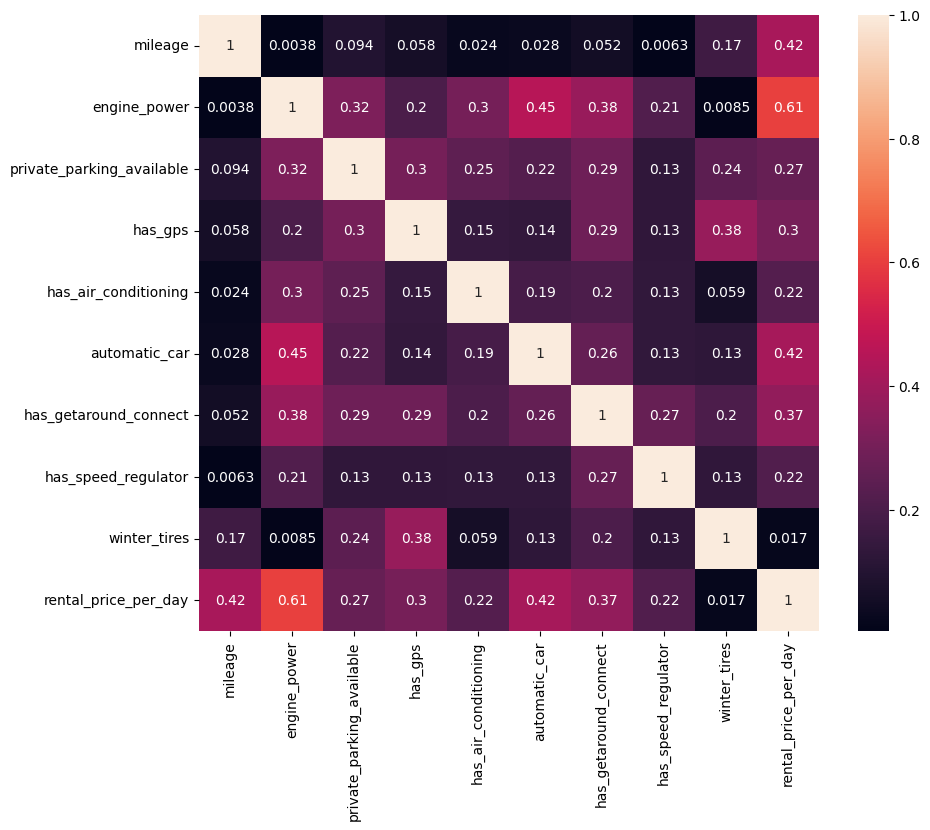

In [17]:
plt.figure(figsize=(10,8))
data_corr=df_price.corr()
sns.heatmap(abs(data_corr),annot=True)

Every feature seems to have correlation with the rental price per day, even tho some are way higher (like engine power with 0.6) and other not very significant (like winter tires with 0.019),
we are gonna start our baseline by keeping every features.

<h2> Model construction <h2>

<h4> Preprocessing <h4>

Target and features split

In [38]:
features_list = [*df_price.columns[0:-1]]
target_variable = 'rental_price_per_day'

X = df_price.loc[:,features_list]
Y = df_price.loc[:,target_variable]
print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Y : 
0    106
2    101
3    158
4    183
5    131
Name: rental_price_per_day, dtype: int64

X :
  model_key  mileage  engine_power    fuel paint_color     car_type  \
0   Citroën   140411           100  diesel       black  convertible   
2   Citroën   183297           120  diesel       white  convertible   
3   Citroën   128035           135  diesel         red  convertible   
4   Citroën    97097           160  diesel      silver  convertible   
5   Citroën   152352           225  petrol       black  convertible   

   private_parking_available  has_gps  has_air_conditioning  automatic_car  \
0                       True     True                 False          False   
2                      False    False                 False          False   
3                       True     True                 False          False   
4                       True     True                 False          False   
5                       True     True                 False          False   

   has_g

Train Test splitting 

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Preprocessing pipeline

In [21]:


num_features = ['mileage', 'engine_power']
cat_features = ['model_key', 'fuel','paint_color','car_type','private_parking_available', 'has_gps',
       'has_air_conditioning', 'automatic_car', 'has_getaround_connect',
       'has_speed_regulator', 'winter_tires']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])


categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) 
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

Preprocessing

In [22]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

<h4> Baseline <h4>

Simple linear regression model

In [23]:
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
Y_train_pred = regressor.predict(X_train) 
print(Y_train_pred)
Y_test_pred = regressor.predict(X_test)
print(Y_test_pred)

[111.38617736 120.95432328 140.08176858 ... 123.43444698 116.84620145
 138.5615245 ]
[106.01265525 161.33013648 112.43618098  68.00478718 126.80192362
 133.0198101  107.1481239   93.69861542 180.85383139 126.25102869
 101.25336358 148.5865573  118.29021441 145.42463945 125.30472441
 173.72946839 129.16543335 111.78845808 104.20303501  76.88427501
 126.04803075 116.14657185 149.17931502 130.27291174 141.82092362
  99.12834925 118.95045205 102.3913006  129.3925877  115.12458151
  98.97209718  99.55247954 165.62999621  88.1725359  142.18436468
 115.95590679 129.18660558 114.4944638   98.96394746  85.35212699
 106.955872   129.60308959 136.8265244  157.00494479 142.83967242
 150.31589601 158.86576258  87.06820742 108.33066685 119.22509611
 154.61788827 138.61240226 110.68290525 109.62102255 105.21055384
  97.93008384 147.66796455 126.34498636 105.22850685 118.66701222
 113.50856548 109.967111   127.20935682 108.98894905 127.1482022
 154.9148424  104.53714668 113.98567951  99.83378883 103.8

In [189]:
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))
print("Difference Train/Test:", ((r2_score(Y_train, Y_train_pred)-r2_score(Y_test, Y_test_pred)) * 100), '%')

R2 score on training set :  0.7105162502206193
R2 score on test set :  0.6840164601831873
Difference Train/Test: 2.649979003743197 %


The model have correct but probably improvable performance, moreover it seems like it is slightly overfitting. Therefore we are gonna try different models to improve the results.

<h4>Ridge model<h4>

As there a lot of differents features with more or less correlation with the target, we are gonna try using the Ridge regularization model which tend to do some kind of feature selection.

In [190]:
model = Ridge()

params = {
    'alpha': [0.01, 0.01,0.02,0.1,1,2,10,20,100]
}
grid_search = GridSearchCV(model, param_grid=params, scoring='r2', cv=5)

grid_search.fit(X_train, Y_train)


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.01, 0.02, 0.1, 1, 2, 10, 20, 100]},
             scoring='r2')

In [191]:
grid_search.best_estimator_

Ridge(alpha=1)

In [192]:
Y_pred_test = grid_search.best_estimator_.predict(X_test)
print("R2 score on training set : ",r2_score(Y_test, Y_pred_test))
Y_pred_train = grid_search.best_estimator_.predict(X_train)
print("R2 score on test set : ",r2_score(Y_train, Y_pred_train))
print("Difference Train/Test:", ((r2_score(Y_train, Y_pred_train)-r2_score(Y_test, Y_pred_test)) * 100), '%')


R2 score on training set :  0.6836904401287813
R2 score on test set :  0.7100761405577388
Difference Train/Test: 2.6385700428957493 %


In [193]:
Y_preds_train = cross_val_score(grid_search.best_estimator_, X_train, Y_train, cv=5)
print("Mean on train set : {}".format(Y_preds_train.mean()))
print("Std on train set : {}".format(Y_preds_train.std()))
Y_preds_test = cross_val_score(grid_search.best_estimator_, X_test, Y_test, cv=5)
print("Mean on train set : {}".format(Y_preds_test.mean()))
print("Std on train set : {}".format(Y_preds_test.std()))

Mean on train set : 0.6999027414646998
Std on train set : 0.009879918841721848
Mean on train set : 0.6710715852226813
Std on train set : 0.021918370936779587


The ridge model have not improved either the score of the model or the overfitting, therefore we are gonna try another very popular model, based on a boosting algorithm, the gradient boosting.

XGboost

In [ ]:
params = {
    'eta' : [0.1],
    'max_depth': [ 5,6,7],
    'min_child_weight': [4,5,6],
    'n_estimators': [171,172,173],

In [233]:
xgboost = XGBRegressor()

params = {
    'eta' : [0.1],
    'max_depth': [ 5,6,7],
    'min_child_weight': [5,6,7],
    'n_estimators': [171,172,173],
    'n_jobs':[1,2]
}
gridsearch = GridSearchCV(xgboost, param_grid = params, cv = 5, verbose = 1) 
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)
print()
y_pred_train = gridsearch.best_estimator_.predict(X_train)
print("R2 score on training set : ",r2_score(Y_train, y_pred_train))
Y_pred_test = gridsearch.best_estimator_.predict(X_test)
print("R2 score on test set : ",r2_score(Y_test, Y_pred_test))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
...Done.
Best hyperparameters :  {'eta': 0.1, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 172, 'n_jobs': 1}
Best validation accuracy :  0.7704099596390769

R2 score on training set :  0.8959146214306439
R2 score on test set :  0.7685996093979782


We still have not resolve the overfitting problem, but we got our best prediction model so we are gonna keep it.
It is important to note that more parameters and features selections have been done, but we only kept the best results here.

<h4> Saving of the model and preprocessor for the API <h4>

In [39]:
from joblib import dump, load
model = XGBRegressor(eta = 0.1, max_depth = 6, min_child_weight = 6, n_estimators =172, njobs = 1)
X = preprocessor.fit_transform(X)
model.fit(X,Y,verbose=False)
model.save_model(r'C:\Users\flori\OneDrive\Bureau\Formation Datascience\Module_8_Deployment\Projet_deployment\Price_prediction_FASTAPI\model_final.json')
dump(preprocessor,r'C:\Users\flori\OneDrive\Bureau\Formation Datascience\Module_8_Deployment\Projet_deployment\Price_prediction_FASTAPI\preprocessor.pkl')


[14:15:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "njobs" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




['C:\\Users\\flori\\OneDrive\\Bureau\\Formation Datascience\\Module_8_Deployment\\Projet_deployment\\Price_prediction_FASTAPI\\preprocessor.pkl']

<h2> Test of the API <h2>

In [6]:
import requests

response = requests.post("http://localhost:4000/predict", json={
  "model_key": "Citroën","mileage": 45000,"engine_power": 130,"fuel": "diesel","paint_color": "red","car_type": "sedan","private_parking_available": True,
  "has_gps": True,"has_air_conditioning": True,"automatic_car": False,"has_getaround_connect": True,"has_speed_regulator": True,"winter_tires": True
  })
print(response.json())

{'prediction': 144.01756286621094}


The API seems to work fine.